In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [47]:
from scipy import mean
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import and_, or_

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

In [10]:
first_measurement = session.query(Measurement).first()
first_measurement.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x26766bcd5c8>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01'}

In [11]:
first_station = session.query(Station).first()
first_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x26766bd9248>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'station': 'USC00519397',
 'latitude': 21.2716}

# Exploratory Climate Analysis

Text(0, 0.5, 'Inches')

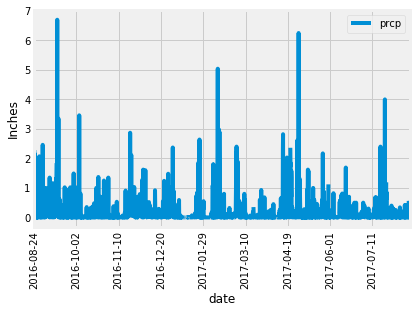

In [79]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Perform a query to retrieve the data and precipitation scores
past_year = (session
             .query(Measurement.prcp, Measurement.date)
             .filter(Measurement.date > '2016-08-23')
             .order_by(Measurement.date)
            )

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.read_sql_query(past_year.statement, session.get_bind())

# Use Pandas Plotting with Matplotlib to plot the data
prcp_plot = prcp_df.plot(kind='line', x ='date', y='prcp', rot=90)
prcp_plot.set_ylabel("Inches")


In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df["prcp"].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

In [17]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [25]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_counts = session.query(Measurement.station)
station_df = pd.read_sql_query(station_counts.statement, session.get_bind())
station_df["station"].value_counts()

USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: station, dtype: int64

In [58]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest_temp = (session.
               query(Measurement.tobs).
               filter(Measurement.station == 'USC00519281').
               order_by(Measurement.tobs).
               first()
              )

highest_temp = (session.
                query(Measurement.tobs).
                filter(Measurement.station == 'USC00519281').
                order_by(Measurement.tobs.desc()).
                first()
               )

#Filter out any null values from tobs column then find average of remaining list
temps = (session.
         query(Measurement.tobs).
         filter(Measurement.station == 'USC00519281')
        )
not_null_temps = []
for temp in temps:
    if type(temp.tobs) == float:
        not_null_temps.append(temp.tobs)
avg_temp = mean(not_null_temps)

print(f'''
        Lowest Temp at USC00519281: {lowest_temp}
        Highest Temp at USC00519281: {highest_temp}
        Average Temp at USC00519281: {avg_temp}
    ''')


        Lowest Temp at USC00519281: (54.0,)
        Highest Temp at USC00519281: (85.0,)
        Average Temp at USC00519281: 71.66378066378067
    


Text(0.5, 0, 'Temperature')

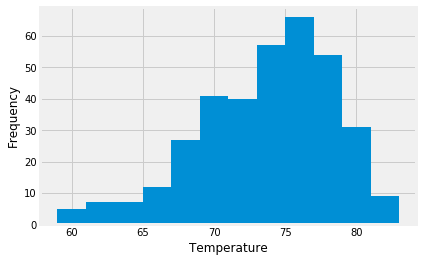

In [70]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_date_active = (session.
                    query(Measurement.date).
                    filter(Measurement.station == 'USC00519281').
                    order_by(Measurement.date.desc())
                    .first()
                   )
past_year_active = (session
             .query(Measurement.tobs, Measurement.date)
             .filter(
                 and_(
                     Measurement.date > '2016-08-18',
                     Measurement.station == 'USC00519281')
            ))

temp_active_df = pd.read_sql_query(past_year_active.statement, session.get_bind())
temp_active_plot = temp_active_df['tobs'].plot.hist(grid=True, bins=12)
temp_active_plot.set_xlabel("Temperature")

## Bonus Challenge Assignment

In [71]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates


# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
